In [44]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Download necessary resources
# nltk.download('stopwords')
# nltk.download('wordnet')

In [46]:
# ========== STEP 1: Load and Label Data ==========
def load_and_label_data(filepath, label):
    df = pd.read_csv(filepath)
    df['label'] = label
    return df

dataframes = [
    load_and_label_data("dataset/preprocessed_spam.csv", "spam"),
    load_and_label_data("dataset/preprocessed_promotions.csv", "promotions"),
    load_and_label_data("dataset/preprocessed_updates.csv", "updates"),
    load_and_label_data("dataset/preprocessed_social.csv", "social"),
]

df = pd.concat(dataframes, ignore_index=True)


In [48]:
# ========== STEP 2: Preprocessing ==========
def clean_text(text):
    text = text.lower()
    tokens = text.split()
    lemmatizer = WordNetLemmatizer()
    cleaned = [lemmatizer.lemmatize(w) for w in tokens if w not in stopwords.words('english')]
    return " ".join(cleaned)

df['text'] = df['Subject'].astype(str) + " " + df['Body'].astype(str)
df['text'] = df['text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_encoded'])

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=200)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
# ========== STEP 3: Build CNN + BiLSTM Model ==========
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(4, activation='softmax'))

# Compile with custom learning rate
adam_optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])


C:\Users\udgir\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
# ========== STEP 4: Training with EarlyStopping & ModelCheckpoint ==========
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4624 - loss: 1.8060

83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.4646 - loss: 1.8004 - val_accuracy: 0.9202 - val_loss: 0.5429
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9391 - loss: 0.4643

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9392 - loss: 0.4635 - val_accuracy: 0.9474 - val_loss: 0.3111
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9741 - loss: 0.2314

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.9740 - loss: 0.2312 - val_accuracy: 0.9457 - val_loss: 0.2389
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9800 - loss: 0.1530

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.9800 - loss: 0.1529 - val_accuracy: 0.9610 - val_loss: 0.1965
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9897 - loss: 0.0978 - val_accuracy: 0.9525 - val_loss: 0.2213
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.9907 - loss: 0.0770 - val_accuracy: 0.9508 - val_loss: 0.2144
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9920 - loss: 0.0619 - val_accuracy: 0.9559 - val_loss: 0.2193
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9951 - loss: 0.0474 - val_accuracy: 0.9474 - val_loss: 0.2694


In [54]:
# ========== STEP 5: Evaluation ==========
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9287 - loss: 0.2884
Test Accuracy: 0.95


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Classification Report:
              precision    recall  f1-score   support

  promotions       0.89      0.94      0.91       401
      social       0.99      0.98      0.99       398
        spam       0.99      0.99      0.99       282
     updates       0.92      0.88      0.90       392

    accuracy                           0.95      1473
   macro avg       0.95      0.95      0.95      1473
weighted avg       0.95      0.95      0.95      1473


Accuracy Score: 0.9450
Macro F1 Score: 0.9484
Weighted F1 Score: 0.9451


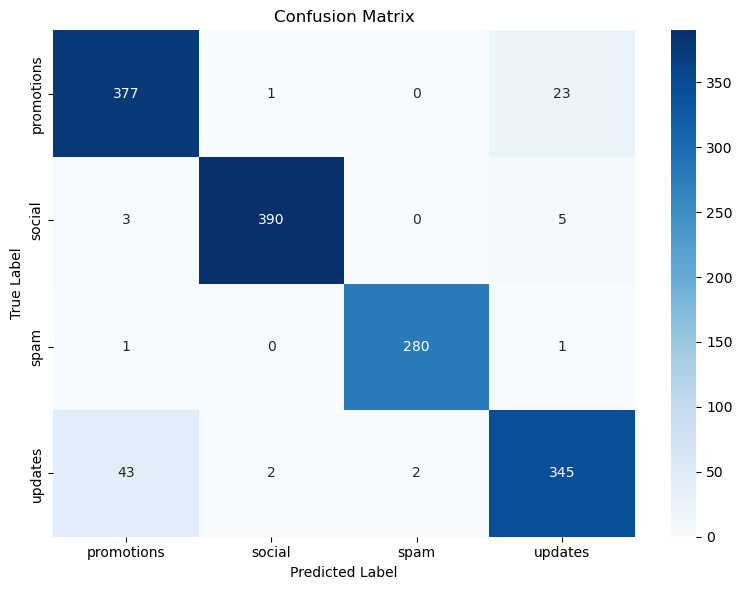

In [56]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities and get class labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Label names
label_names = label_encoder.classes_

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

# Print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy Score: {accuracy:.4f}")

# Print F1 scores
macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()